In [135]:
#import libraries
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

In [136]:
#load data
if not os.path.exists("./data"):
    raise ValueError('You need to import the data first, run load_data.py')
else:
    #df = pd.read_csv('data/iris_data.csv',sep='\t')
    df = pd.read_csv('data/data_titanic.csv',sep='\t')

In [ ]:
#user-defined target for classification
target_column = 'survived'
#target_column = 'target'

## Initial exploration

In [137]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [138]:
#report nans
df.isnull().mean()

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [ ]:
# Checking for data imbalance
df[target_column].value_counts()

## Supporting functions

In [140]:
## functions for preprocessing

#check for duplicates
def check_duplicates(df):
    has_dup = df.duplicated()
    true_dup = np.where(has_dup == True)
    if len(true_dup[0]) > 0:
        print("Data has", len(true_dup[0]), "duplicates")
        df.drop_duplicates(keep='first', inplace=True)
    else:
        print("No duplicates found")
    return df

#function for one-hot encoding
def one_hot(df, column_names):
    for col in column_names:
        dummies = pd.get_dummies(df[[col]].astype('category'),drop_first=True)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([col], axis=1)
    return df

#function for adding interaction terms between all columns
def add_full_interactions(df,degree=2):
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=degree)
    X_poly = poly.fit_transform(df)
    column_names = list(poly.get_feature_names_out())
    X_poly = pd.DataFrame(X_poly,columns=column_names)
    return X_poly

#function for adding interaction terms between select columns
def add_interactions(df,columns,degree=2):
    poly = PolynomialFeatures(interaction_only=True, include_bias=False, degree=degree)
    X_poly = poly.fit_transform(df[columns])
    column_names = list(poly.get_feature_names_out())
    X_poly = pd.DataFrame(X_poly,columns=column_names)
    X_poly = pd.concat([df, X_poly.drop(columns,axis=1)], axis=1)
    return X_poly

#function for computing sigmoid (e.g. to look at logistic regression fit)
def sigmoid(x,b):
    return 1 / (1 + np.exp(-(b+x)))

#min-max scale vector to pre-specified range
def linmap(vector, new_min, new_max):
    vector = np.array(vector)
    old_min = np.min(vector)
    old_max = np.max(vector)
    
    # Avoid division by zero if the old_min equals old_max
    if old_min == old_max:
        return np.full_like(vector, new_min if old_min == old_max else new_max)
    
    # Scale the vector
    scaled_vector = (vector - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return scaled_vector


## Main function for cleaning

In [141]:
def clean_data(df,target_column):
    ### main preprocessing function:

    ## done on train and test set together
    
    #clean up column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df.columns = [col.replace('(',  '') for col in df.columns]
    df.columns = [col.replace(')',  '') for col in df.columns]

    #drop column names that we don't need
    df = df.drop(['embark_town', 'alive', 'deck','who','class'],axis=1)

    #check and report on duplicate data
    df = check_duplicates(df)

    #run train-test split
    #note: X still contains the y-variable in the 'target' column, this is because it 
    #easier to remove rows / apply cleaning steps without having to do it separately 
    #for the target data vector.
    X = df
    X_train, X_test, _, _ = train_test_split(X, df[target_column], random_state=1234) 

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)


    ## done separately for train and test

    #imputing
    X_train.age = X_train.age.fillna(X_train.age.median())
    X_test.age  = X_test.age.fillna(X_test.age.median())

    #non-linear scaling of values
    X_train['fare'] = X_train.fare.apply(lambda x: np.log(x) if x > 0 else 0)
    X_test['fare']  = X_test.fare.apply(lambda x: np.log(x) if x > 0 else 0)

    #define / identify columns for range normalization
    df['pclass'] = df['pclass'].astype('category')
    columns_to_scale = df.select_dtypes(include='number').columns.drop(target_column) #identify the numberic columns
  

    #remove outliers from the training set
    outlier_trheshold = X_train['fare'].median()+(X_train['fare'].std()*3)
    print(str(np.sum(X_train['fare'] > outlier_trheshold)) + " outliers detected")
    X_train = X_train[X_train['fare'] < outlier_trheshold]
    X_train.reset_index(drop=True, inplace=True)    

    #range normalization
    scaler = MinMaxScaler()
    scaler.set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
    X_test_scaled  = scaler.transform(X_test[columns_to_scale])
    X_train = pd.concat([X_train_scaled, X_train.drop(columns_to_scale,axis=1)], axis=1)
    X_test  = pd.concat([X_test_scaled, X_test.drop(columns_to_scale,axis=1)], axis=1)

    #separate the target
    y_train = X_train[target_column]
    X_train = X_train.drop(target_column,axis=1)
    y_test = X_test[target_column]
    X_test = X_test.drop(target_column,axis=1)

    return X_train, X_test, y_train, y_test

##  Main function for Feature engineering

In [142]:
def feature_engineer(df,columns_to_interact,columns_to_dummycode):

    #add interaction terms
    df = add_interactions(df,columns_to_interact)

    #one-hot encode categorical variables
    df = one_hot(df,columns_to_dummycode)

    return df

## Clean the data and make features

In [143]:
X_train, X_test, y_train, y_test = clean_data(df,target_column)

Data has 111 duplicates
2 outliers detected


In [144]:
columns_to_interact  = ['adult_male','alone']
columns_to_dummycode = ['pclass','sex','embarked','adult_male','alone','adult_male alone']

X_train = feature_engineer(X_train,columns_to_interact,columns_to_dummycode)
X_test  = feature_engineer(X_test,columns_to_interact,columns_to_dummycode)

## Check the model

<Axes: >

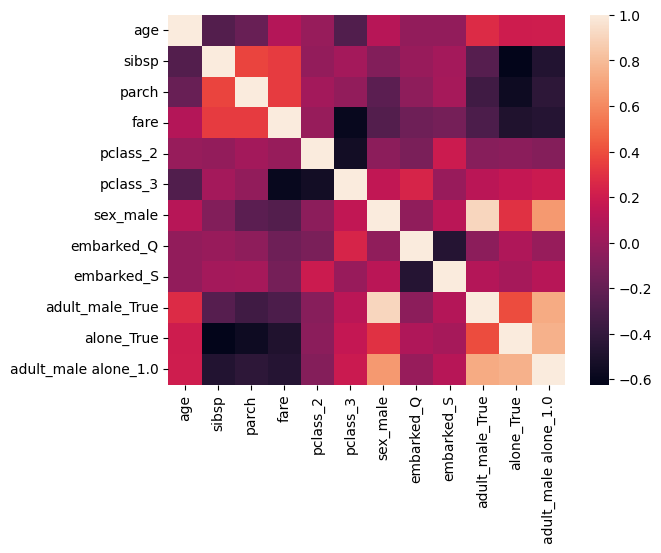

In [145]:
#plot correlation between regressors
sns.heatmap(X_train.corr())

## Fit the model

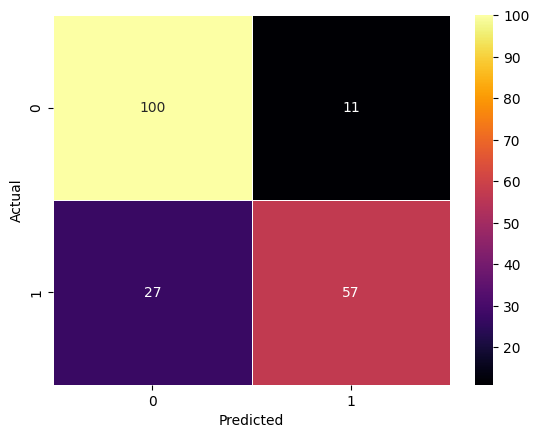

Precision:  0.8382352941176471
Recall:  0.6785714285714286
F1-score:  0.7500000000000001
Accuracy:  0.8051282051282052


In [146]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, cmap='inferno', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))

TypeError: BaseEstimator.get_params() missing 1 required positional argument: 'self'

In [ ]:

LogisticRegression.get_params().keys() 

# Define parameter grid for randomized search
param_grid = {"n_neighbors" : [2,4,3,5,10], #this actually defines the model you use
              "weights" : ["uniform", "distance"],
              "p" : [1, 2, 3],
              "algorithm": ["ball_tree", "kd_tree", "brute"]
             }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)
# Fit randomized search object to data
start = timer()
rs.fit(X_train_preprocessed, y_train)
end = timer()
rgs_time = end-start
# Best score
print('Best score:', round(rs.best_score_, 3))
# Best parameters
print('Best parameters:', rs.best_params_)
# Assigning the fitted KNNClassifier model with best parameter combination to a new variable knn_best
knn_best_rs = rs.best_estimator_
# Making predictions on the test set
y_pred_test_rs = knn_best_rs.predict(X_test_preprocessed)
# Let us print out the performance of our model on the test set.
rknn_accuracy = print_pretty_summary('KNNClassifier model (randomizedGSCV)', knn_best_rs, y_test, y_pred_test_rs)

print(f"Grid search took {gs_time} seconds to run with accuracy: {knn_accuracy:f}")
print(f"Randomized Grid search took {rgs_time} seconds to run with accuracy: {rknn_accuracy:f}")
